<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2020/blob/master/NLP/SWT_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/tensor2tensor/master/tensor2tensor/test_data/vocab.translate_ende_wmt32k.32768.subwords
!pip install -qq git+git://github.com/arampacha/reformer_fastai.git

!gdown --id 1-AVxs5Hpb7wxRq33hiTI6uteZkqROtYc
!gdown --id 1-9vZZ-xr-Fbi1BP34peuc1kEJURoL1Jd
!gdown --id 18Cov7aNhoeOizqSqdXN6Y9xiC8jaMyrC

In [ ]:
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
  !pip install -Uqq fastai einops datasets wandb yappi gprof2dot pyinstrument nbdev fastcore
  import os
  os.kill(os.getpid(), 9)

In [1]:
import six
from six import int2byte, unichr, PY2, iterkeys, iteritems, text_type
from six.moves import range as six_range
import collections

import unicodedata
from itertools import chain

from fastai.basics import *
from fastai.text.all import *

In [2]:
class SubwordTextEncoder(Transform):
  """Class for invertibly encoding text using a limited vocabulary.

  Invertibly encodes a native string as a sequence of subtokens from a limited
  vocabulary.

  A SubwordTextEncoder is built from a corpus (so it is tailored to the text in
  the corpus), and stored to a file. See text_encoder_build_subword.py.

  It can then be loaded and used to encode/decode any text.

  Encoding has four phases:

  1. Tokenize into a list of tokens.  Each token is a unicode string of either
     all alphanumeric characters or all non-alphanumeric characters.  We drop
     tokens consisting of a single space that are between two alphanumeric
     tokens.

  2. Escape each token.  This escapes away special and out-of-vocabulary
     characters, and makes sure that each token ends with an underscore, and
     has no other underscores.

  3. Represent each escaped token as a the concatenation of a list of subtokens
     from the limited vocabulary.  Subtoken selection is done greedily from
     beginning to end.  That is, we construct the list in order, always picking
     the longest subtoken in our vocabulary that matches a prefix of the
     remaining portion of the encoded token.

  4. Concatenate these lists.  This concatenation is invertible due to the
     fact that the trailing underscores indicate when one list is finished.

  """

  def __init__(self, filename=None, is_lm=True, add_bos=False):
    """Initialize and read from a file, if provided.

    Args:
      filename: filename from which to read vocab. If None, do not load a
        vocab
    """
    self.native_to_unicode = (lambda s: s.decode("utf-8")) if PY2 else (lambda s: s)
    self._ALPHANUMERIC_CHAR_SET = set(unichr(i) for i in six_range(sys.maxunicode) if (unicodedata.category(unichr(i)).startswith("L") or unicodedata.category(unichr(i)).startswith("N")))
    self.PAD = "<pad>"
    self.EOS = "<EOS>"
    self.RESERVED_TOKENS = [self.PAD, self.EOS]
    self.NUM_RESERVED_TOKENS = len(self.RESERVED_TOKENS)
    self.PAD_ID = self.RESERVED_TOKENS.index(self.PAD)  # Normally 0
    self.EOS_ID = self.RESERVED_TOKENS.index(self.EOS)  # Normally 1
    self._UNESCAPE_REGEX = re.compile(r"\\u|\\\\|\\([0-9]+);")
    self._ESCAPE_CHARS = set(u"\\_u;0123456789")
    self.ls_lm = is_lm
    self.add_bos = add_bos


    self._alphabet = set()
    self.filename = filename
    if filename is not None:
      self._load_from_file(filename)
    super(SubwordTextEncoder, self).__init__()

  def encodes(self, s):
    """Converts a native string to a list of subtoken ids.

    Args:
      s: a native string.
    Returns:
      a list of integers in the range [0, vocab_size)
    """
    return self.__call__(s)

  @typedispatch
  def __call__(self, s:str, **kwargs):
    out = self._tokens_to_subtoken_ids(self._encode(text=self.native_to_unicode(s)))
    if self.add_bos: out = [self.PAD_ID] + out # Imran Add <pad> to begining of sentence
    if self.ls_lm: return LMTensorText(out)
    else: return TensorText(out)

  def encode_without_tokenizing(self, token_text):
    """Converts string to list of subtoken ids without calling tokenizer.

    This treats `token_text` as a single token and directly converts it
    to subtoken ids. This may be useful when the default tokenizer doesn't
    do what we want (e.g., when encoding text with tokens composed of lots of
    nonalphanumeric characters). It is then up to the caller to make sure that
    raw text is consistently converted into tokens. Only use this if you are
    sure that `encode` doesn't suit your needs.

    Args:
      token_text: A native string representation of a single token.
    Returns:
      A list of subword token ids; i.e., integers in the range [0, vocab_size).
    """
    return self._tokens_to_subtoken_ids([self.native_to_unicode(token_text)])

  def decodes(self, ids, strip_extraneous=False):
    """Converts a sequence of subtoken ids to a native string.

    Args:
      ids: a list of integers in the range [0, vocab_size)
      strip_extraneous: bool, whether to strip off extraneous tokens
        (EOS and PAD).

    Returns:
      a native string
    """
    if strip_extraneous:
      ids = strip_ids(ids, list(six_range(self._num_reserved_ids or 0)))
    return self.unicode_to_native(
        self._decode(self._subtoken_ids_to_tokens(ids)))

  def decode_list(self, ids):
    return [self._subtoken_id_to_subtoken_string(s) for s in ids]

  @property
  def vocab_size(self):
    """The subtoken vocabulary size."""
    return len(self._all_subtoken_strings)

  def _tokens_to_subtoken_ids(self, tokens):
    """Converts a list of tokens to a list of subtoken ids.

    Args:
      tokens: a list of strings.
    Returns:
      a list of integers in the range [0, vocab_size)
    """
    ret = []
    for token in tokens:
      ret.extend(self._token_to_subtoken_ids(token))
    return ret

  def _token_to_subtoken_ids(self, token):
    """Converts token to a list of subtoken ids.

    Args:
      token: a string.
    Returns:
      a list of integers in the range [0, vocab_size)
    """
    cache_location = hash(token) % self._cache_size
    cache_key, cache_value = self._cache[cache_location]
    if cache_key == token:
      return cache_value
    ret = self._escaped_token_to_subtoken_ids(
        self._escape_token(token, self._alphabet))
    self._cache[cache_location] = (token, ret)
    return ret

  def _subtoken_ids_to_tokens(self, subtokens):
    """Converts a list of subtoken ids to a list of tokens.

    Args:
      subtokens: a list of integers in the range [0, vocab_size)
    Returns:
      a list of strings.
    """
    concatenated = "".join(
        [self._subtoken_id_to_subtoken_string(s) for s in subtokens])
    split = concatenated.split("_")
    ret = []
    for t in split:
      if t:
        unescaped = self._unescape_token(t + "_")
        if unescaped:
          ret.append(unescaped)
    return ret

  def _subtoken_id_to_subtoken_string(self, subtoken):
    """Converts a subtoken integer ID to a subtoken string."""
    if 0 <= subtoken < self.vocab_size:
      return self._all_subtoken_strings[subtoken]
    return u""

  def _escaped_token_to_subtoken_strings(self, escaped_token):
    """Converts an escaped token string to a list of subtoken strings.

    Args:
      escaped_token: An escaped token as a unicode string.
    Returns:
      A list of subtokens as unicode strings.
    """
    # NOTE: This algorithm is greedy; it won't necessarily produce the "best"
    # list of subtokens.
    ret = []
    start = 0
    token_len = len(escaped_token)
    while start < token_len:
      for end in six_range(
          min(token_len, start + self._max_subtoken_len), start, -1):
        subtoken = escaped_token[start:end]
        if subtoken in self._subtoken_string_to_id:
          ret.append(subtoken)
          start = end
          break

      else:  # Did not break
        # If there is no possible encoding of the escaped token then one of the
        # characters in the token is not in the alphabet. This should be
        # impossible and would be indicative of a bug.
        assert False, "Token substring not found in subtoken vocabulary."

    return ret

  def _escaped_token_to_subtoken_ids(self, escaped_token):
    """Converts an escaped token string to a list of subtoken IDs.

    Args:
      escaped_token: An escaped token as a unicode string.
    Returns:
      A list of subtoken IDs as integers.
    """
    return [
        self._subtoken_string_to_id[subtoken]
        for subtoken in self._escaped_token_to_subtoken_strings(escaped_token)
    ]

  @classmethod
  def build_from_generator(cls,
                           generator,
                           target_size,
                           max_subtoken_length=None,
                           reserved_tokens=None):
    """Builds a SubwordTextEncoder from the generated text.

    Args:
      generator: yields text.
      target_size: int, approximate vocabulary size to create.
      max_subtoken_length: Maximum length of a subtoken. If this is not set,
        then the runtime and memory use of creating the vocab is quadratic in
        the length of the longest token. If this is set, then it is instead
        O(max_subtoken_length * length of longest token).
      reserved_tokens: List of reserved tokens. The global variable
        `RESERVED_TOKENS` must be a prefix of `reserved_tokens`. If this
        argument is `None`, it will use `RESERVED_TOKENS`.

    Returns:
      SubwordTextEncoder with `vocab_size` approximately `target_size`.
    """
    token_counts = collections.defaultdict(int)
    for item in generator:
      for tok in self._encode(self.native_to_unicode(item)):
        token_counts[tok] += 1
    encoder = cls.build_to_target_size(
        target_size, token_counts, 1, 1e3,
        max_subtoken_length=max_subtoken_length,
        reserved_tokens=reserved_tokens)
    return encoder

  @classmethod
  def build_to_target_size(cls,
                           target_size,
                           token_counts,
                           min_val,
                           max_val,
                           max_subtoken_length=None,
                           reserved_tokens=None,
                           num_iterations=4):
    """Builds a SubwordTextEncoder that has `vocab_size` near `target_size`.

    Uses simple recursive binary search to find a minimum token count that most
    closely matches the `target_size`.

    Args:
      target_size: Desired vocab_size to approximate.
      token_counts: A dictionary of token counts, mapping string to int.
      min_val: An integer; lower bound for the minimum token count.
      max_val: An integer; upper bound for the minimum token count.
      max_subtoken_length: Maximum length of a subtoken. If this is not set,
        then the runtime and memory use of creating the vocab is quadratic in
        the length of the longest token. If this is set, then it is instead
        O(max_subtoken_length * length of longest token).
      reserved_tokens: List of reserved tokens. The global variable
        `RESERVED_TOKENS` must be a prefix of `reserved_tokens`. If this
        argument is `None`, it will use `RESERVED_TOKENS`.
      num_iterations: An integer; how many iterations of refinement.

    Returns:
      A SubwordTextEncoder instance.

    Raises:
      ValueError: If `min_val` is greater than `max_val`.
    """
    if min_val > max_val:
      raise ValueError("Lower bound for the minimum token count "
                       "is greater than the upper bound.")
    if target_size < 1:
      raise ValueError("Target size must be positive.")

    if reserved_tokens is None:
      reserved_tokens = RESERVED_TOKENS

    def bisect(min_val, max_val):
      """Bisection to find the right size."""
      present_count = (max_val + min_val) // 2
      #tf.logging.info("Trying min_count %d" % present_count)
      subtokenizer = cls()
      subtokenizer.build_from_token_counts(
          token_counts, present_count, num_iterations,
          max_subtoken_length=max_subtoken_length,
          reserved_tokens=reserved_tokens)

      # Being within 1% of the target size is ok.
      is_ok = abs(subtokenizer.vocab_size - target_size) * 100 < target_size
      # If min_val == max_val, we can't do any better than this.
      if is_ok or min_val >= max_val or present_count < 2:
        return subtokenizer

      if subtokenizer.vocab_size > target_size:
        other_subtokenizer = bisect(present_count + 1, max_val)
      else:
        other_subtokenizer = bisect(min_val, present_count - 1)

      if other_subtokenizer is None:
        return subtokenizer

      if (abs(other_subtokenizer.vocab_size - target_size) <
          abs(subtokenizer.vocab_size - target_size)):
        return other_subtokenizer
      return subtokenizer

    return bisect(min_val, max_val)

  def build_from_token_counts(self,
                              token_counts,
                              min_count,
                              num_iterations=4,
                              reserved_tokens=None,
                              max_subtoken_length=None):
    """Train a SubwordTextEncoder based on a dictionary of word counts.

    Args:
      token_counts: a dictionary of Unicode strings to int.
      min_count: an integer - discard subtokens with lower counts.
      num_iterations: an integer.  how many iterations of refinement.
      reserved_tokens: List of reserved tokens. The global variable
        `RESERVED_TOKENS` must be a prefix of `reserved_tokens`. If this
        argument is `None`, it will use `RESERVED_TOKENS`.
      max_subtoken_length: Maximum length of a subtoken. If this is not set,
        then the runtime and memory use of creating the vocab is quadratic in
        the length of the longest token. If this is set, then it is instead
        O(max_subtoken_length * length of longest token).

    Raises:
      ValueError: if reserved is not 0 or len(RESERVED_TOKENS). In this case, it
        is not clear what the space is being reserved for, or when it will be
        filled in.
    """
    if reserved_tokens is None:
      reserved_tokens = RESERVED_TOKENS
    else:
      # There is not complete freedom in replacing RESERVED_TOKENS.
      for default, proposed in zip(RESERVED_TOKENS, reserved_tokens):
        if default != proposed:
          raise ValueError("RESERVED_TOKENS must be a prefix of "
                           "reserved_tokens.")

    # Initialize the alphabet. Note, this must include reserved tokens or it can
    # result in encoding failures.
    alphabet_tokens = chain(iterkeys(token_counts),
                            [self.native_to_unicode(t) for t in reserved_tokens])

    self._init_alphabet_from_tokens(alphabet_tokens)

    # Bootstrap the initial list of subtokens with the characters from the
    # alphabet plus the escaping characters.
    self._init_subtokens_from_list(list(self._alphabet),
                                   reserved_tokens=reserved_tokens)

    # We build iteratively.  On each iteration, we segment all the words,
    # then count the resulting potential subtokens, keeping the ones
    # with high enough counts for our new vocabulary.
    if min_count < 1:
      min_count = 1
    for i in six_range(num_iterations):
      #tf.logging.info("Iteration {0}".format(i))

      # Collect all substrings of the encoded token that break along current
      # subtoken boundaries.
      subtoken_counts = collections.defaultdict(int)
      for token, count in iteritems(token_counts):
        iter_start_time = time.time()
        escaped_token = self._escape_token(token, self._alphabet)
        subtokens = self._escaped_token_to_subtoken_strings(escaped_token)
        start = 0
        for subtoken in subtokens:
          last_position = len(escaped_token) + 1
          if max_subtoken_length is not None:
            last_position = min(last_position, start + max_subtoken_length)

          for end in six_range(start + 1, last_position):
            new_subtoken = escaped_token[start:end]
            subtoken_counts[new_subtoken] += count
          start += len(subtoken)
        iter_time_secs = time.time() - iter_start_time
        if iter_time_secs > 0.1:
          print(u"Processing token [{0}] took {1} seconds, consider "
                          "setting Text2TextProblem.max_subtoken_length to a "
                          "smaller value.".format(token, iter_time_secs))

      # Array of sets of candidate subtoken strings, by length.
      len_to_subtoken_strings = []
      for subtoken_string, count in iteritems(subtoken_counts):
        lsub = len(subtoken_string)
        if count >= min_count:
          while len(len_to_subtoken_strings) <= lsub:
            len_to_subtoken_strings.append(set())
          len_to_subtoken_strings[lsub].add(subtoken_string)

      # Consider the candidates longest to shortest, so that if we accept
      # a longer subtoken string, we can decrement the counts of its prefixes.
      new_subtoken_strings = []
      for lsub in six_range(len(len_to_subtoken_strings) - 1, 0, -1):
        subtoken_strings = len_to_subtoken_strings[lsub]
        for subtoken_string in subtoken_strings:
          count = subtoken_counts[subtoken_string]
          if count >= min_count:
            # Exclude alphabet tokens here, as they must be included later,
            # explicitly, regardless of count.
            if subtoken_string not in self._alphabet:
              new_subtoken_strings.append((count, subtoken_string))
            for l in six_range(1, lsub):
              subtoken_counts[subtoken_string[:l]] -= count

      # Include the alphabet explicitly to guarantee all strings are encodable.
      new_subtoken_strings.extend((subtoken_counts.get(a, 0), a)
                                  for a in self._alphabet)
      new_subtoken_strings.sort(reverse=True)

      # Reinitialize to the candidate vocabulary.
      new_subtoken_strings = [subtoken for _, subtoken in new_subtoken_strings]
      if reserved_tokens:
        escaped_reserved_tokens = [
            self._escape_token(self.native_to_unicode(t), self._alphabet)
            for t in reserved_tokens
        ]
        new_subtoken_strings = escaped_reserved_tokens + new_subtoken_strings

      self._init_subtokens_from_list(new_subtoken_strings)
      #tf.logging.info("vocab_size = %d" % self.vocab_size)

  @property
  def all_subtoken_strings(self):
    return tuple(self._all_subtoken_strings)

  def dump(self):
    """Debugging dump of the current subtoken vocabulary."""
    subtoken_strings = [(i, s)
                        for s, i in iteritems(self._subtoken_string_to_id)]
    print(u", ".join(u"{0} : '{1}'".format(i, s)
                     for i, s in sorted(subtoken_strings)))

  def _init_subtokens_from_list(self, subtoken_strings, reserved_tokens=None):
    """Initialize token information from a list of subtoken strings.

    Args:
      subtoken_strings: a list of subtokens
      reserved_tokens: List of reserved tokens. We must have `reserved_tokens`
        as None or the empty list, or else the global variable `RESERVED_TOKENS`
        must be a prefix of `reserved_tokens`.

    Raises:
      ValueError: if reserved is not 0 or len(RESERVED_TOKENS). In this case, it
        is not clear what the space is being reserved for, or when it will be
        filled in.
    """
    if reserved_tokens is None:
      reserved_tokens = []

    if reserved_tokens:
      self._all_subtoken_strings = reserved_tokens + subtoken_strings
    else:
      self._all_subtoken_strings = subtoken_strings

    # we remember the maximum length of any subtoken to avoid having to
    # check arbitrarily long strings.
    self._max_subtoken_len = max([len(s) for s in subtoken_strings])
    self._subtoken_string_to_id = {
        s: i + len(reserved_tokens)
        for i, s in enumerate(subtoken_strings) if s
    }
    # Initialize the cache to empty.
    self._cache_size = 2 ** 20
    self._cache = [(None, None)] * self._cache_size

  def _init_alphabet_from_tokens(self, tokens):
    """Initialize alphabet from an iterable of token or subtoken strings."""
    # Include all characters from all tokens in the alphabet to guarantee that
    # any token can be encoded. Additionally, include all escaping characters.
    self._alphabet = {c for token in tokens for c in token}
    self._alphabet |= self._ESCAPE_CHARS

  def _load_from_file_object(self, f):
    """Load from a file object.

    Args:
      f: File object to load vocabulary from
    """
    subtoken_strings = []
    for line in f:
      s = line.rstrip()
      # Some vocab files wrap words in single quotes, but others don't
      if ((s.startswith("'") and s.endswith("'")) or
          (s.startswith("\"") and s.endswith("\""))):
        s = s[1:-1]
      subtoken_strings.append(self.native_to_unicode(s))
    self._init_subtokens_from_list(subtoken_strings)
    self._init_alphabet_from_tokens(subtoken_strings)

  def _load_from_file(self, filename):
    """Load from a vocab file."""
    if not Path(filename).exists():
      raise ValueError("File %s not found" % filename)
    with Path(filename).open() as f:
      self._load_from_file_object(f)

  def store_to_file(self, filename, add_single_quotes=True):
    with Path(filename).open('w') as f:
      for subtoken_string in self._all_subtoken_strings:
        if add_single_quotes:
          f.write("'" + self.unicode_to_native(subtoken_string) + "'\n")
        else:
          f.write(self.unicode_to_native(subtoken_string) + "\n")
		
  def unicode_to_native(self,s):
    if PY2:
      return s.encode("utf-8") if is_unicode(s) else s
    else:
      return s

  def _escape_token(self,token, alphabet):
    if not isinstance(token, text_type):
      raise ValueError("Expected string type for token, got %s" % type(token))

    token = token.replace(u"\\", u"\\\\").replace(u"_", u"\\u")
    ret = [c if c in alphabet and c != u"\n" else r"\%d;" % ord(c) for c in token]
    return u"".join(ret) + "_"


  def _unescape_token(self,escaped_token):
    def match(m):
      if m.group(1) is None:
        return u"_" if m.group(0) == u"\\u" else u"\\"

      try:
        return unichr(int(m.group(1)))
      except (ValueError, OverflowError) as _:
        return u"\u3013"  # Unicode for undefined character.

    trimmed = escaped_token[:-1] if escaped_token.endswith("_") else escaped_token
    return self._UNESCAPE_REGEX.sub(match, trimmed)

  def _encode(self,text):
    if not text:
      return []
    ret = []
    token_start = 0
    # Classify each character in the input string
    is_alnum = [c in self._ALPHANUMERIC_CHAR_SET for c in text]
    for pos in six_range(1, len(text)):
      if is_alnum[pos] != is_alnum[pos - 1]:
        token = text[token_start:pos]
        if token != u" " or token_start == 0:
          ret.append(token)
        token_start = pos
    final_token = text[token_start:]
    ret.append(final_token)
    return ret

  def _decode(self,tokens):
    token_is_alnum = [t[0] in self._ALPHANUMERIC_CHAR_SET for t in tokens]
    ret = []
    for i, token in enumerate(tokens):
      if i > 0 and token_is_alnum[i - 1] and token_is_alnum[i]:
        ret.append(u" ")
      ret.append(token)
    #if self.add_bos: ret.pop()
    return TitledStr("".join(ret))

In [3]:
wonder = "I wonder how the moon got it's shine?"
tok = SubwordTextEncoder(filename='./vocab.translate_ende_wmt32k.32768.subwords', add_bos=True)
tok_wonder = tok(wonder)

In [4]:
assert type(tok_wonder) == LMTensorText
assert len(tok_wonder) == 12
assert tok.decode(tok_wonder) == wonder

AssertionError: ignored

In [ ]:
tok_wonder, tok.decode(tok_wonder), wonder

In [ ]:
#!pip install -qq datasets
#from datasets import load_dataset
#train_dataset = load_dataset('wmt_t2t')

In [5]:
#test_df = pd.DataFrame(train_dataset['test']['translation'], columns=train_dataset['test']['translation'][0].keys())
#val_df = pd.DataFrame(train_dataset['validation']['translation'], columns=train_dataset['validation']['translation'][0].keys())
#train_df = pd.DataFrame(train_dataset['train']['translation'], columns=train_dataset['train']['translation'][0].keys())

In [6]:
#train_df.to_feather('./train_df')
#val_df.to_feather('./val_df')
#test_df.to_feather('./test_df')

In [7]:
val_df=pd.read_feather('./val_df')
train_df=pd.read_feather('./train_df')
test_df=pd.read_feather('./test_df')

In [8]:
train_df

,de,en
0,Wiederaufnahme der Sitzungsperiode,Resumption of the session
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.","I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period."
2,"Wie Sie feststellen konnten, ist der gefürchtete ""Millenium-Bug "" nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.","Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful."
3,Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.,"You have requested a debate on this subject in the course of the next few days, during this part-session."
4,"Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.","In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union."
...,...,...
4592284,Tatsächlich sollten sie die Gleichberechtigung aller marginalisierten Gruppen voranbringen.,"Indeed, they should advance equality for all marginalized groups."
4592285,"Es ist dieser Hintergrund, vor dem die mittel- und langfristigen Folgen des Zika-Virus zu bewältigen sind.",Zika’s medium- and long-term consequences must be addressed with this in mind.
4592286,"Wenn eine Frau ein Kind mit einem angeborenen Syndrom zur Welt bringt, das auf das Zika-Virus zurückzuführen ist, sollte der Umgang damit auf der Würde, dem Wert und den Rechten jedes einzelnen Menschen gründen.","When a woman gives birth to a child with a congenital syndrome deriving from the Zika virus, the response should be grounded in the dignity, value, and rights of each individual."
4592287,"Die Prozesse, die einzelne Menschen und Gruppen in Armut halten und ihnen die grundlegenden Rechte als Bürger verwehren, müssen erkannt werden.",It should acknowledge the processes that keep certain individuals and groups in poverty and that deny them the basic rights of citizens.


In [9]:
## Replace test_df with train_df here

df=pd.concat([ test_df, val_df], ignore_index=True)#test_df #['en']
cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])

df['en_lens'] = df['en'].str.len()
df['de_lens'] = df['de'].str.len()

def add_eos(text):
    return text + f' <EOS>'

def add_pad(text):
    return  f'<pad> '+ text

en_tfms = [ColReader("en"), add_eos, tok]
de_tfms = [ColReader("de"), add_eos, tok]

srtd_dl=partial(SortedDL, shuffle = True)
dsets = Datasets(df, [en_tfms, de_tfms], splits=splits, dl_type=srtd_dl)
pad_seq2seq = partial(pad_input, pad_idx=tok.PAD_ID, pad_fields=[0,1])

In [10]:
dls = dsets.dataloaders(bs=8, seq_len=128, before_batch=pad_seq2seq)

In [11]:
dls.show_batch(max_n=4)

,text,text_
0,"<pad>Israel's current prime minister, Netanyahu 'the hawk', is a typical example of a fascist politician, loyal to the international bankers, who does everything to instigate war with Iran, which would, due to its membership in the Shanghai Cooperation Organisation (China, India, Russia, Pakistan, ...) lead to a greater threat of global conflict, and through its control of the Hormuz Strait, where 20% of the world's oil must sail (the channel is only 2 miles wide), to the destruction of the world's economy. <EOS>","<pad>Derderzeitige Premierminister Israels, der Falke Netanjahu, ist ein typisches Beispiel eines faschismusanfälligen, den internationalen Bankern loyal ergebenen Politikers, der alles dafür tut, um einen Krieg mit dem Iran zu entfachen, welcher sich angesichts der Mitgliedschaft Irans in der Schanghaier Organisation für Zusammenarbeit (China, Indien, Russland, Pakistan...), rasch zu einem globalen Konflikt ausweiten könnte, und bei dem es wegen der Kontrolle Irans über die nur 2 Meilen breite Straße von Hormus, über die 20% der weltweiten Erdöllieferungen laufen, zu einer Zerstörung der Weltwirtschaft kommen könnte. <EOS>"
1,"<pad>Shereferred to sayings such as: ""Holzauge sei wachsam"" (keep your eyes peeled), ""wie Schuppen von den Augen fallen"" (like scales falling from one's eyes), ""ein Auge auf jemand werfen"" (to cast an eye on someone), ""den Seinen gibt's der Herr im Schlaf"" (good things come to some when they sleep) and ""seine Hände in Unschuld waschen"" (to wash one's hands of something). <EOS><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>","<pad>Sienannte Sprichwörter wie: Holzauge sei wachsam, wie Schuppen von den Augen fallen, ein Auge auf jemand werfen, den Seinen gibt's der Herr im Schlaf, seine Hände in Unschuld waschen. <EOS><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"
2,"<pad>Itconceals one challenge that will not be solved so quickly - how to force a person, who is physically in a very limited space to believe that he is walking along an open, almost limitless space; we are working on the concept of treadmills (not at all like in clubs), moving platforms, and giant balloons. <EOS><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>","<pad>Hierverbirgt sich eine weitere Aufgabe, mit der wir noch lange zu kämpfen haben werden, nämlich einen Menschen, der sich physisch in einem geschlossenen Raum befindet, glauben zu lassen, er befinde sich stattdessen in einem offenen, praktisch unendlichen Raum; hier arbeiten wir an Konzepten mit Laufbändern (anderen als in Fitnessstudios), beweglichen Plattformen sowie großen Kugeln. <EOS><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"
3,"<pad>DanielleOckwell, who was supervised by Lord and asked for child protection training because she was concerned about his behaviour, testified she found the YMCA Caringbah children's services manager Jacqui Barnat who supervised Lord ""very intimidating and hard to approach a lot of the time."" <EOS><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>","<pad>DanielleOckwell, deren Vorgesetzter Lord war und die um eine Schulung 

In [12]:
#xb,yb=dls.one_batch()
#tok.decode(yb[0].detach().numpy())

In [13]:
en_vocab_sz=tok.vocab_size
de_vocab_sz=tok.vocab_size

#en_vocab_sz = 1000
#ga_vocab_sz = 1000
d_model = 768
d_ff = 2048

In [14]:
class CombineInputOutputCallback(Callback):
    '''Callback to combine the input and target text into self.xb'''
    def __init__(self): pass
    def before_batch(self): 
        self.learn.xb = (self.xb[0], self.yb[0][:, :-1])
        

class RemoveEOSCallback(Callback):
    '''
        Shift the target presented to the model during training to remove the "eos" token as 
        we don't want the model to learn to translate EOS when it sees EOS.
        
        In practice we actually mask the EOS token as due to batching the last token will often be a <pad> token,
        not EOS
    '''
    def __init__(self, eos_idx): self.eos_idx=eos_idx
    def before_batch(self):        
        eos_mask=(self.learn.xb[1]!=self.eos_idx)
        sz=torch.tensor(self.learn.xb[1].size())
        sz[1]=sz[1]-1
        self.learn.xb = (self.learn.xb[0], self.learn.xb[1][eos_mask].view((sz[0],sz[1])))
        print(self.learn.xb[0])


class LossTargetShiftCallback(Callback):
    '''
        Shift the target shown to the loss to exclude the "bos" token as the first token we want predicted
        should be an actual word, not the "bos" token (as we have already given the model "bos" )
    '''
    def __init__(self): pass
    def after_pred(self):
        self.learn.yb = (self.learn.yb[0][:,1:],)


In [15]:
from reformer_fastai.transformer import TransformerEncDec
cbs = [CombineInputOutputCallback(),LossTargetShiftCallback()]# RemoveEOSCallback(eos_idx=tok.EOS_ID)]#,

model = TransformerEncDec(en_vocab_sz, de_vocab_sz, d_model=d_model, heads=8, 
                 max_seq_len=256, pad_idx=tok.PAD_ID, tie_weights=True, 
                 attn_dropout=0.0, ff_dropout=0.0, emb_dropout=0.0,
                 pos_enc='fixed', d_ff=d_ff, comb_attn=False)

learn = Learner(dls, model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

No module named 'axial_positional_embedding'


SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

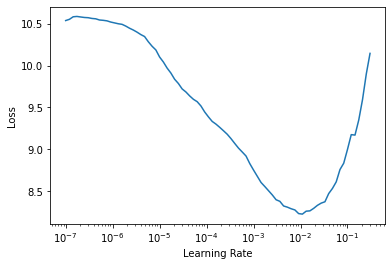

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,corpus_bleu,time
0,6.492111,6.384750,0.160797,0.137795,01:33
1,6.331139,6.318521,0.160797,0.137795,01:32
2,6.292962,6.297194,0.160797,0.137795,01:33
3,6.221331,6.293276,0.160797,0.137795,01:33
4,6.184604,6.287811,0.160797,0.137795,01:33
